In [2]:
import pandas as pd
import nilmtk
import matplotlib.pyplot as plt
import random
import sys
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import h5py
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.datastore import HDFDataStore
from matplotlib import rcParams
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from S2P import ShortSeq2PointDisaggregator
import time
import metrics

In [3]:
print("========== OPEN DATASETS ============")
train_house02 = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
train_house03 = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
train_house02.set_window(end="5-2-2011")
train_house03.set_window(end="28-4-2011")

val = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
val.set_window(start="16-5-2011")

test = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
test.set_window(end="5-3-2011")

train_building = [2,3]
val_building = 1
test_building = 1
sample_period = 3
meter_key = 'fridge'

train_mains = []
train_mains.append(train_house02.buildings[train_building[0]].elec.mains().all_meters()[1])
train_mains.append(train_house03.buildings[train_building[1]].elec.mains().all_meters()[0])
# train_mains.append(train.buildings[train_building[2]].elec.mains().all_meters()[0])

train_meters = []
train_meters.append(train_house02.buildings[train_building[0]].elec.submeters()[meter_key])
train_meters.append(train_house03.buildings[train_building[1]].elec.submeters()[meter_key])


test_mains = test.buildings[test_building].elec.mains().all_meters()[0]
test_meters = test.buildings[test_building].elec.submeters()[meter_key]

val_mains = val.buildings[val_building].elec.mains().all_meters()[0]
val_meters = val.buildings[val_building].elec.submeters()[meter_key]

S2P = ShortSeq2PointDisaggregator(window_size=600)

========== OPEN DATASETS ============
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 600, 30)           330       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 600, 30)           7230      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 600, 40)           7240      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 600, 50)           10050     
_________________________________________________________________
dropout (Dropout)            (None, 600, 50)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 600, 50)           12550     
_________________________________________________________________
dropout_1 (Dropout

In [3]:
start = time.time()
print("========== TRAIN ============")

history01 = S2P.train(train_mains[0], train_meters[0], epochs=10)
history02 = S2P.train(train_mains[1], train_meters[1], epochs=10)

S2P.export_model("model_CNN_win600.h5")

end = time.time()
print("Train =", end-start, "seconds.")

========== TRAIN ============
(312388, 600, 1)
(312388,)
356.2344
84.37994
219.84592
61.480576
128
Epoch 1/10
1953/1953 [==============================] - 120s 57ms/step - loss: 0.1514 - val_loss: 0.1405
Epoch 2/10
1953/1953 [==============================] - 173s 88ms/step - loss: 0.0654 - val_loss: 0.0903
Epoch 3/10
1953/1953 [==============================] - 143s 73ms/step - loss: 0.0537 - val_loss: 0.1041
Epoch 4/10
1953/1953 [==============================] - 210s 108ms/step - loss: 0.0481 - val_loss: 0.1009
Epoch 5/10
1953/1953 [==============================] - 228s 117ms/step - loss: 0.0469 - val_loss: 0.0847
Epoch 6/10
1953/1953 [==============================] - 324s 166ms/step - loss: 0.0439 - val_loss: 0.0842
Epoch 7/10
1953/1953 [==============================] - 262s 134ms/step - loss: 0.0430 - val_loss: 0.0786
Epoch 8/10
1953/1953 [==============================] - 225s 115ms/step - loss: 0.0408 - val_loss: 0.0772
Epoch 9/10
1953/1953 [==============================] - 

In [4]:
print("========== DISAGGREGATE ============")
disag_filename = 'disag_CNN_win600.h5'
output = HDFDataStore(disag_filename, 'w')
S2P.disaggregate(test_mains, output, train_meters[0], sample_period=sample_period)
output.close()

========== DISAGGREGATE ============
New sensible chunk: 5533
New sensible chunk: 26611
New sensible chunk: 7822
New sensible chunk: 6689
New sensible chunk: 653
New sensible chunk: 29766
New sensible chunk: 13757
New sensible chunk: 32510
New sensible chunk: 34806
New sensible chunk: 20284
New sensible chunk: 64862
New sensible chunk: 31931
New sensible chunk: 41483
New sensible chunk: 37554
New sensible chunk: 8252


In [4]:
ground_truth = test_meters

========== Plot ============


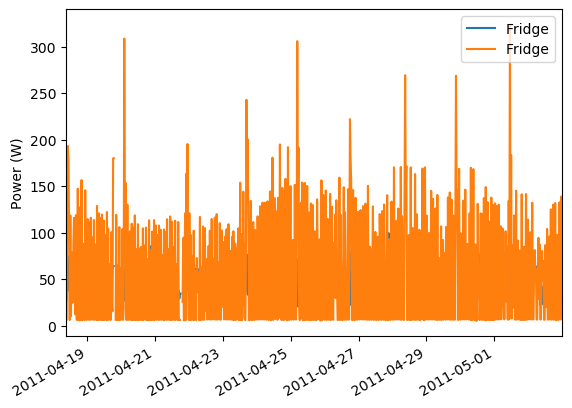

In [4]:
result = DataSet('disag_CNN_win600.h5')
res_elec = result.buildings[test_building].elec

print("========== Plot ============")

predicted = res_elec[meter_key]
ground_truth = test_meters
import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
plt.show()

In [5]:
ground_truth.on_power_threshold()

10

In [6]:
good_sections_pre = predicted.good_sections()
good_sections_pre

[TimeFrame(start='2011-04-18 09:52:06-04:00', end='2011-04-18 13:58:45-04:00', empty=False),
 TimeFrame(start='2011-04-18 14:33:03-04:00', end='2011-04-19 12:13:36-04:00', empty=False),
 TimeFrame(start='2011-04-19 12:44:12-04:00', end='2011-04-19 18:45:18-04:00', empty=False),
 TimeFrame(start='2011-04-19 20:50:03-04:00', end='2011-04-20 01:54:30-04:00', empty=False),
 TimeFrame(start='2011-04-20 02:25:33-04:00', end='2011-04-20 02:28:12-04:00', empty=False),
 TimeFrame(start='2011-04-20 02:58:48-04:00', end='2011-04-21 03:17:06-04:00', empty=False),
 TimeFrame(start='2011-04-21 06:47:12-04:00', end='2011-04-21 17:45:03-04:00', empty=False),
 TimeFrame(start='2011-04-21 20:11:24-04:00', end='2011-04-22 22:46:54-04:00', empty=False),
 TimeFrame(start='2011-04-22 23:18:30-04:00', end='2011-04-24 03:48:48-04:00', empty=False),
 TimeFrame(start='2011-04-24 04:22:21-04:00', end='2011-04-24 20:46:33-04:00', empty=False),
 TimeFrame(start='2011-04-24 21:17:12-04:00', end='2011-04-27 02:50:18

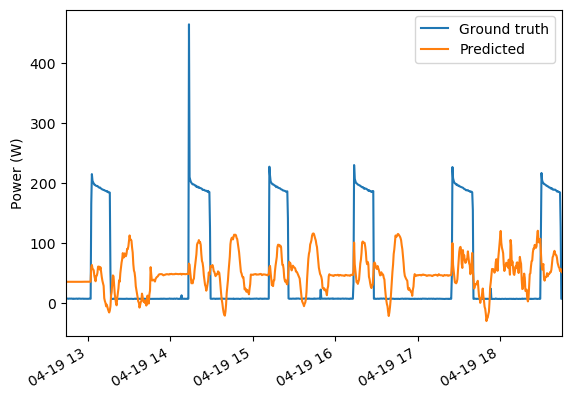

In [7]:
ground_truth.plot(timeframe=good_sections_pre[2])
predicted.plot(timeframe=good_sections_pre[2])
plt.legend(['Ground truth', 'Predicted'])
plt.show()

In [8]:
print(history01)
print(history02)

{'loss': [0.15135458111763, 0.06540383398532867, 0.05374776944518089, 0.04812243580818176, 0.04685894772410393, 0.04385759308934212, 0.04302089288830757, 0.04077649489045143, 0.040846459567546844, 0.03975145146250725], 'val_loss': [0.14045172929763794, 0.09031248092651367, 0.10414490848779678, 0.10093090683221817, 0.08465086668729782, 0.08417043834924698, 0.07858909666538239, 0.07719745486974716, 0.11081817001104355, 0.0810241550207138]}
{'loss': [0.5036783218383789, 0.4019152820110321, 0.3776015639305115, 0.3669608533382416, 0.3629233241081238, 0.3585567772388458, 0.3546885848045349, 0.35327109694480896, 0.3495766520500183, 0.34902116656303406], 'val_loss': [0.8793700337409973, 0.9406894445419312, 0.9191460013389587, 0.9149734973907471, 0.8756354451179504, 0.8895555138587952, 0.8606683611869812, 0.925385057926178, 0.8657323122024536, 0.8488332033157349]}


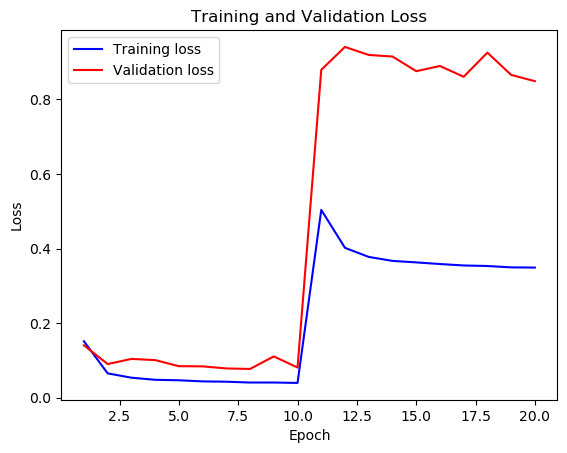

In [9]:
# Combine the history
history = {}
history['loss'] = history01['loss'] + history02['loss']
history['val_loss'] = history01['val_loss'] + history02['val_loss']

# Plot the loss curve
epochs = range(1, len(history['loss']) + 1)
plt.plot(epochs, history['loss'], 'b', label='Training loss')
plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [8]:
print("========== RESULTS ============")
result = DataSet('disag_CNN_win600.h5')
res_elec = result.buildings[test_building].elec
rpaf = metrics.recall_precision_accuracy_f1(res_elec[meter_key], test_meters)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(res_elec[meter_key], test_meters)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(res_elec[meter_key], test_meters)))

========== RESULTS ============
============ Recall: 0.8521438931219741
============ Precision: 0.40317202586331874
============ Accuracy: 0.4145352093552165
============ F1 Score: 0.5473691116651358
============ Relative error in total energy: 0.11809690556577163
============ Mean absolute error(in Watts): 66.38453975196434
